In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import PIL
from PIL import Image
from scipy import ndimage as ndi
import cv2
import os
from os import listdir
from sklearn.utils import shuffle

import keras
# import keras_metrics
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.optimizers import SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint

In [4]:
directory_root = "/Users/Tara8082/GIT/ProjectGIT/project_5/PlantVillage"
print(len(listdir(directory_root)))

16


In [5]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [6]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
                
        for single_plant_disease_image in plant_disease_folder_list :
            if single_plant_disease_image == ".DS_Store" :
                plant_disease_folder_list.remove(single_plant_disease_image)

        for image in plant_disease_folder_list:
            image_directory = f"{directory_root}/{plant_folder}/{image}"
            if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                image_list.append(image_directory)
                label_list.append(plant_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Image loading completed


In [7]:
img_info = pd.DataFrame({'image_path':image_list,'label':label_list})
print(img_info.head())
print(len(img_info))

                                          image_path           label
0  /Users/Tara8082/GIT/ProjectGIT/project_5/Plant...  Tomato_healthy
1  /Users/Tara8082/GIT/ProjectGIT/project_5/Plant...  Tomato_healthy
2  /Users/Tara8082/GIT/ProjectGIT/project_5/Plant...  Tomato_healthy
3  /Users/Tara8082/GIT/ProjectGIT/project_5/Plant...  Tomato_healthy
4  /Users/Tara8082/GIT/ProjectGIT/project_5/Plant...  Tomato_healthy
20636


In [8]:
#new column (empty)
img_info["labels_integer"] = None
#index of new column
index_labels_integer = img_info.columns.get_loc("labels_integer")
#index of species column
index_species = img_info.columns.get_loc("label")
#to assign numeric labels starting with 0 for the first species
k = 0 
for i in range(len(img_info)):
    if i == 0:
        img_info.iloc[i, index_labels_integer] = k #here, k == 0
    if i > 0:
        if img_info.iloc[i-1, index_species] == img_info.iloc[i, index_species]:
            img_info.iloc[i, index_labels_integer] = k
        else:
            k += 1
            img_info.iloc[i, index_labels_integer] = k
img_info.tail()

,image_path,label,labels_integer
20631,/Users/Tara8082/GIT/ProjectGIT/project_5/Plant...,Potato___healthy,14
20632,/Users/Tara8082/GIT/ProjectGIT/project_5/Plant...,Potato___healthy,14
20633,/Users/Tara8082/GIT/ProjectGIT/project_5/Plant...,Potato___healthy,14
20634,/Users/Tara8082/GIT/ProjectGIT/project_5/Plant...,Potato___healthy,14
20635,/Users/Tara8082/GIT/ProjectGIT/project_5/Plant...,Potato___healthy,14


In [9]:
img_info = shuffle(img_info)
list_vectors = []

for image_path in img_info.image_path:
    #read as rgb array
    img = Image.open(image_path)
    size = (64, 64)
    img = img.resize(size, PIL.Image.ANTIALIAS)  
    img_array = np.array(img)
    #append image vector to list
    list_vectors.append(img_array)
    
print(len(list_vectors))

20636


In [10]:
X = np.stack((list_vectors))
Y =  img_info['labels_integer']
print(X.shape)

(20636, 64, 64, 3)


In [11]:
X = X/255
Y_one_hot = keras.utils.to_categorical(Y, num_classes=15)
print(Y.shape, Y_one_hot.shape)

(20636,) (20636, 15)


In [12]:
cd /Users/Tara8082/GIT/ProjectGIT/project_5

/Users/Tara8082/GIT/ProjectGIT/project_5


In [13]:
np.savez("x_images_arrayscnn", X)
np.savez("y_numeric_labelscnn", Y_one_hot)

In [14]:
x_npz = np.load("/Users/Tara8082/GIT/ProjectGIT/project_5/x_images_arrayscnn.npz")
X = x_npz['arr_0']

y_npz = np.load("/Users/Tara8082/GIT/ProjectGIT/project_5/y_numeric_labelscnn.npz")
Y_one_hot = y_npz['arr_0']

print(X.shape)

(20636, 64, 64, 3)


In [32]:
print(Y_one_hot.shape)

(20636, 15)


In [22]:
split_train = 0.8 #train 0.8, validate 0.1, test 0.1
split_val = 0.9
index_train = int(split_train*len(X))
index_val = int(split_val*len(X))

X_train = X[:index_train]
X_val = X[index_train:index_val]
X_test = X[index_val:]

Y_train = Y_one_hot[:index_train]
Y_val = Y_one_hot[index_train:index_val]
Y_test = Y_one_hot[index_val:]


print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)

(16508, 64, 64, 3) (2064, 64, 64, 3) (2064, 64, 64, 3) (16508, 15) (2064, 15) (2064, 15)


In [23]:
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]) 
num_classes = 15 # multi class problem

model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.7))
model.add(Flatten())
model.add(Dense(1000))
model.add(Activation('relu'))
model.add(Dropout(0.7))
model.add(Dense(num_classes, activation='softmax'))

# multi class = categorical cross entropy
model.compile(optimizer=keras.optimizers.Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-8, amsgrad=False), loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 60, 60, 32)        2432      
_________________________________________________________________
activation_3 (Activation)    (None, 60, 60, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 64)        51264     
_________________________________________________________________
activation_4 (Activation)    (None, 26, 26, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 13, 13, 64)       

In [62]:
%%time

best_model_file = "disease_selected_100.h5" #H5 for arrays
best_model = ModelCheckpoint(best_model_file, monitor='val_loss', verbose=1, save_best_only=True)

# fit the model
print('Training model...')
results = model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_data=(X_val, Y_val), callbacks=[best_model])
print('Training finished.')

# save the best model
print('Loading the best model...')
model = load_model(best_model_file)
print('Best model loaded!')

Training model...
Epoch 1/100
258/258 [==============================] - ETA: 0s - loss: 0.1351 - accuracy: 0.9580
Epoch 00001: val_loss improved from inf to 0.03358, saving model to disease_selected_100.h5
258/258 [==============================] - 57s 221ms/step - loss: 0.1351 - accuracy: 0.9580 - val_loss: 0.0336 - val_accuracy: 0.9913
Epoch 2/100
258/258 [==============================] - ETA: 0s - loss: 0.1024 - accuracy: 0.9674
Epoch 00002: val_loss did not improve from 0.03358
258/258 [==============================] - 58s 225ms/step - loss: 0.1024 - accuracy: 0.9674 - val_loss: 0.0349 - val_accuracy: 0.9903
Epoch 3/100
258/258 [==============================] - ETA: 0s - loss: 0.0891 - accuracy: 0.9702
Epoch 00003: val_loss did not improve from 0.03358
258/258 [==============================] - 51s 197ms/step - loss: 0.0891 - accuracy: 0.9702 - val_loss: 0.0416 - val_accuracy: 0.9889
Epoch 4/100
258/258 [==============================] - ETA: 0s - loss: 0.0831 - accuracy: 0.973

In [63]:
model = load_model('/Users/Tara8082/GIT/ProjectGIT/project_5/disease_selected_100.h5')
print('Best model loaded!')

Best model loaded!


In [69]:
# evaluate model
test = model.evaluate(X_test, Y_test)

65/65 [==============================] - 1s 22ms/step - loss: 0.0327 - accuracy: 0.9927


In [ ]:
acc = results.history['accuracy']
val_acc = results.history['val_accuracy']
loss = results.history['loss']
val_loss = results.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

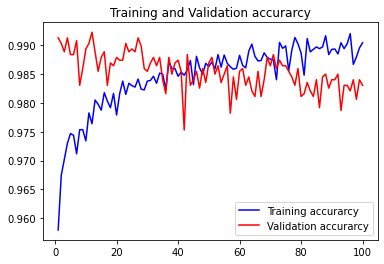

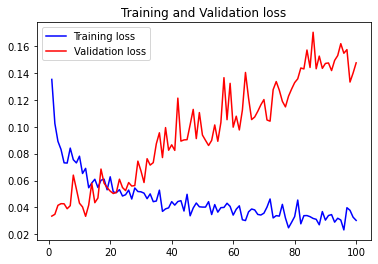

In [67]:
acc = results.history['accuracy']
val_acc = results.history['val_accuracy']
loss = results.history['loss']
val_loss = results.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [61]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Predicting on Trained Model
- load best model
- load the image,
- convert image to array
- use predict function to predict the class
- define the entire class in an array



In [59]:
from keras.preprocessing.image import img_to_array


imgpath='/Users/Tara8082/GIT/ProjectGIT/project_5/PlantVillage/Pepper__bell___healthy/0ade14b6-8937-43ea-93eb-98343af6bae7___JR_HL 8026.JPG'

default_image_size = tuple((256, 256))
imar = convert_image_to_array(imgpath)
npimagelist = np.array([imar], dtype=np.float16) / 225.0
pred = model.predict(npimagelist)